In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import warnings
import nltk
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 400

In [2]:
df = pd.read_csv('../data/data_clean_2.csv')
df.columns

Index(['Unnamed: 0', 'subreddit', 'selftext', 'author', 'title', 'score',
       'num_comments', 'utc_datetime_str', 'fullmessage', 'text_length',
       'text_word_count', 'contain_aws', 'contain_az', 'timestamp',
       'post_age_days', 'has_comments', 'target', 'contain_invalid_char'],
      dtype='object')

In [3]:
df.shape

(9876, 18)

### Model
1. Base line
2. Naive Bayes
3. Logistic Regression
4. Random Forest

In [4]:
results = pd.DataFrame([], columns = ['model', 'vectoriser', 'hyperparameters','recall/sensitivity','accuracy'])

In [5]:
X= df['fullmessage']
y= df['target']

## Understanding which metric to use for model evaluation and confusion matrix

For this project we assign AWS as positive and Azure as negative classification because the hypothetical company relies more on AWS cloud services in comparison to azure. Hence there is much more urgency for production team to respond to AWS related events and the model need to classify AWS events correctly. 

Accuracy: Ability to classify correctly over the total number of records. For example, for 50 AWS events and 50 Azure events, to obtain 80% accuracy the following criterias neeeds to be met:
* 40 AWS events and 40 Azure events classified correctly
* 60 AWS events and 20 Azure events classified correctly
* 20 AWS events and 60 Azure events classified correctly
* This is no need to place any emphasis on which class is predicted more correctly.

Precision: Ability to correctly identify AWS posts (TP/(TP+FP)). For example, for 50 AWS events and 50 Azure events, to get 80%, the following criteria needs to be met: 
* 40 AWS correctly predicted as AWS events, 10 Azure events wrongly predicted as AWS events
* This score will become lower if more Azure events are misclassified.

TPR/Recall/Sensitivity: Ability to correctly identify all AWS posts (TP/(TP+FN)). For example, for 50 AWS events and 50 Azure events, to get 80%, the following criteria needs to be met: 
* 40 AWS correctly predicted as AWS events, remaining 10 AWS events wrongly predicted as Azure events
* This score will become lower if more AWS events are misclassified.

Specificity: Ability to correctly identify Azure posts (TN/(TN+FP)). For example, for 50 AWS events and 50 Azure events, to get 80%, the following criteria needs to be met: 
* 40 Azure correctly predicted as Azure events, remaining 10 Azure wrongly predicted as Aws events
* This score will become lower if more Azure events are misclassified.

F1 score: Weighted average of precision and TPR/recall/sensitivity.

In this case we choose both accuracy and TPR/recall/sensitivity, because there is priority for AWS events to be correctly identified.

## 1. Baseline model

The baseline model is a simple model that checks if keyword "Aws" and "Azure" exists in the post to determine the post classification. 

1. Contains keyword 'AWS' or 'Amazon' -> Aws
2. Contains keyowrd 'Microsoft' or 'Azure' -> Azure
3. Randomly classify if contains both or neither keywords

In [6]:
import random
random.randint(0, 1)

1

In [7]:
def word_exist(text, key_words):    
    return any(i in text.lower() for i in key_words)

def base_model(x):
    if word_exist(x, ['aws','amazon']):
        return 1
    elif word_exist(x, ['azure','microsoft']):
        return 0
    else:
        return random.randint(0, 1)

In [8]:
y_test = df['target']
y_pred = df['fullmessage'].apply(lambda x: base_model(x))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
print(confusion_matrix(y_true= y_test, y_pred=y_pred))

[[4256  715]
 [1149 3756]]


In [9]:
# Calculate the sensitivty
score = tp / (tp+fn)
acc = (tp+tn)/(tp+tn+fp+fn)
print('TPR/Recall/Sensitivity:', score)
print('Accuracy:', acc)

TPR/Recall/Sensitivity: 0.7657492354740061
Accuracy: 0.8112596192790603


In [10]:
results = results.append({'model': 'baseline', 
                          'vectoriser': 'N/A',
                          'hyperparameters': 'N/A', 
                          'recall/sensitivity': score,
                          'accuracy':acc,
                         }, ignore_index=True)
results

,model,vectoriser,hyperparameters,recall/sensitivity,accuracy
0,baseline,N/A,N/A,0.765749,0.81126


## 2a. Naive Bayes with CountVectoriser

We vectorise the text into a frequency vector before passing it into a Naive Bayes model for classification. The CountVectoriser handles the tokenising, lemmatisation and removal of punctuations under the hood. Naive Bayes classifier is based on features being independent of one another. Here we use Multinomial Naive Bayes classifier for document classification, to see which comment belong to Aws or Azure category.

* Count vectoriser splits text into its component words as a vector
* We get the frequency of each word as a vector against the entire list of words

The disadvantages are: <br>
1. Cannot identify important or less important words
2. Consider the highest frequency words as the most important
3. No relationship between words


In [11]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# Pipeline with 2 stages
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [1_000, 3_000, 5_000],
    'cvec__min_df': [3],
    #'cvec__max_df': [0.25,0.5,0.75],
    'cvec__ngram_range': [(1,2),(1,3)]
}


# Instantiate GridSearchCV.

gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)


# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_features': [1000, 3000, 5000],
                         'cvec__min_df': [3],
                         'cvec__ngram_range': [(1, 2), (1, 3)]})

In [12]:
print(gs.best_estimator_.steps)

[('cvec', CountVectorizer(max_features=3000, min_df=3, ngram_range=(1, 2),
                stop_words='english')), ('nb', MultinomialNB())]


In [13]:
# What's the best score?
print(gs.best_score_)

0.939388531511967


In [14]:
# Score model on training set.
gs.score(X_train, y_train)

0.9505743651753326

In [15]:
# Score model on testing set.
gs.score(X_test, y_test)

0.9303680981595092

In [16]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate the score
score = tp / (tp+fn)
acc = (tp+tn)/(tp+tn+fp+fn)
print('TPR/Recall/Sensitivity:', score)
print('Accuracy:', acc)

TPR/Recall/Sensitivity: 0.9085855466337245
Accuracy: 0.9303680981595092


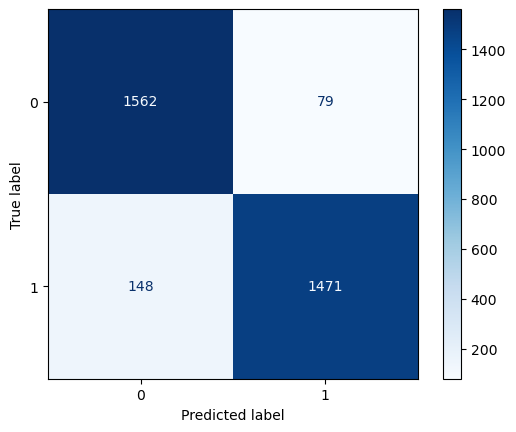

In [17]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [18]:
results = results.append({'model': 'Naive Bayes', 
                          'vectoriser': 'Count Vectoriser',
                          'hyperparameters': gs.best_estimator_.steps,
                          'recall/sensitivity': score,
                          'accuracy': acc}, ignore_index=True)
results

,model,vectoriser,hyperparameters,recall/sensitivity,accuracy
0,baseline,N/A,N/A,0.765749,0.811260
1,Naive Bayes,Count Vectoriser,"[(cvec, CountVectorizer(max_features=3000, min_df=3, ngram_range=(1, 2),\n stop_words='english')), (nb, MultinomialNB())]",0.908586,0.930368


### 2b. Naive Bayes with TF-IDF Vectoriser
Naive Bayes classifier is based on features being independent of one another. Here we use Multinomial Naive Bayes classifier for document classification, to see which comment belong to Aws or Azure category. The features used will be the frequency of the words present in the document transformed by the TF-IDF vectoriser via the pipeline. TF (Term Frequenct) and IDF (Inverse Document Frequency) method improves the following: <br>

1. Same as Count Vectoriser, it takes into account of the frequency of words
2. But it also consider words that less important and remove them from analysis
3. Build less complex model by reducing the dimensions needed



In [19]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [20]:

# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [21]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 1000, 3000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__min_df': [3],
    'tvec__max_features': [1_000, 3_000, 5_000],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,2),(1,3)]
}

In [22]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

In [23]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [1000, 3000, 5000],
                         'tvec__min_df': [3],
                         'tvec__ngram_range': [(1, 2), (1, 3)],
                         'tvec__stop_words': ['english']})

In [24]:
print(gs_tvec.best_estimator_.steps)

[('tvec', TfidfVectorizer(max_features=5000, min_df=3, ngram_range=(1, 2),
                stop_words='english')), ('nb', MultinomialNB())]


In [25]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.9579806529625151

In [26]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.9291411042944785

In [27]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the score
score = tp / (tp+fn)
acc = (tp+tn)/(tp+tn+fp+fn)
print('TPR/Recall/Sensitivity:', score)
print('Accuracy:', acc)

TPR/Recall/Sensitivity: 0.9129092032118592
Accuracy: 0.9291411042944785


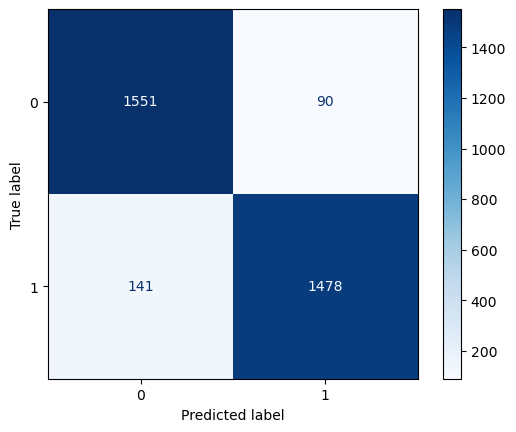

In [28]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');

In [29]:
results = results.append({'model': 'Naive Bayes', 
                          'vectoriser': 'TF IDF Vectoriser',
                          'hyperparameters': gs_tvec.best_estimator_.steps,
                          'recall/sensitivity': score,
                          'accuracy': acc}, ignore_index=True)
results

,model,vectoriser,hyperparameters,recall/sensitivity,accuracy
0,baseline,N/A,N/A,0.765749,0.811260
1,Naive Bayes,Count Vectoriser,"[(cvec, CountVectorizer(max_features=3000, min_df=3, ngram_range=(1, 2),\n stop_words='english')), (nb, MultinomialNB())]",0.908586,0.930368
2,Naive Bayes,TF IDF Vectoriser,"[(tvec, TfidfVectorizer(max_features=5000, min_df=3, ngram_range=(1, 2),\n stop_words='english')), (nb, MultinomialNB())]",0.912909,0.929141


### 3. Logistic Regression with TF-IDF Vectoriser

Unlike linear regression which works with continuous data, logistic regression works well with binary classification, where the target in this case is either "AWS" or "Azure" classification. Generally the logistic model returns a value between 0 and 1 and value below 0.5 is rounded down to 0 and value above 0.5 is rounded up to 1.

The logistic regression has multiple independent variables determined by text transformed by the TF-IDF vectoriser, where each feature will be assigned a coefficient.

To reduce complexity and overfitting, regularisation such as l1 (lasso), l2 (ridge) or elasticnet can be used to "penalise" the coefficients of the features in the logtistic regression model. This ensures that the model generalize better on unseen data.


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

pipe_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=500, random_state=42))
])

params_lr = {
    'tvec__min_df': [3],
    'tvec__max_features': [1_000, 3_000, 5_000],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,2),(1,3)],
    'lr__penalty': ['none','l2']
}

gs_lr = GridSearchCV(pipe_lr, param_grid=params_lr, scoring='accuracy', verbose=0, cv=5)
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42))]),
             param_grid={'lr__penalty': ['none', 'l2'],
                         'tvec__max_features': [1000, 3000, 5000],
                         'tvec__min_df': [3],
                         'tvec__ngram_range': [(1, 2), (1, 3)],
                         'tvec__stop_words': ['english']},
             scoring='accuracy')

In [31]:
print(gs_lr.best_estimator_.steps)

[('tvec', TfidfVectorizer(max_features=5000, min_df=3, ngram_range=(1, 3),
                stop_words='english')), ('lr', LogisticRegression(max_iter=500, random_state=42))]


In [32]:
gs_lr.score(X_train, y_train)

0.9771765417170496

In [33]:
gs_lr.score(X_test, y_test)

0.9503067484662576

In [34]:
# Get predictions
preds_lr = gs_lr.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_lr).ravel()

# Calculate the score
score = tp / (tp+fn)
acc = (tp+tn)/(tp+tn+fp+fn)
print('TPR/Recall/Sensitivity:', score)
print('Accuracy:', acc)

TPR/Recall/Sensitivity: 0.9660284126003706
Accuracy: 0.9503067484662576


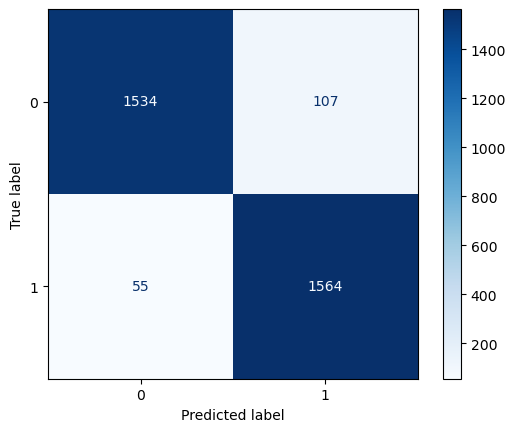

In [35]:
plot_confusion_matrix(gs_lr, X_test, y_test, cmap='Blues', values_format='d');

In [36]:
results = results.append({'model': 'Logistic Regression', 
                          'vectoriser': 'TF IDF Vectoriser',
                          'hyperparameters': gs_lr.best_estimator_.steps,
                          'recall/sensitivity': score,
                          'accuracy': acc}, ignore_index=True)
results

,model,vectoriser,hyperparameters,recall/sensitivity,accuracy
0,baseline,N/A,N/A,0.765749,0.811260
1,Naive Bayes,Count Vectoriser,"[(cvec, CountVectorizer(max_features=3000, min_df=3, ngram_range=(1, 2),\n stop_words='english')), (nb, MultinomialNB())]",0.908586,0.930368
2,Naive Bayes,TF IDF Vectoriser,"[(tvec, TfidfVectorizer(max_features=5000, min_df=3, ngram_range=(1, 2),\n stop_words='english')), (nb, MultinomialNB())]",0.912909,0.929141
3,Logistic Regression,TF IDF Vectoriser,"[(tvec, TfidfVectorizer(max_features=5000, min_df=3, ngram_range=(1, 3),\n stop_words='english')), (lr, LogisticRegression(max_iter=500, random_state=42))]",0.966028,0.950307


### 4. Random Forest with TF-IDF Vectoriser

Decision trees start with asking a question on "Does this event belong to AWS or Azure services?" A random forest model is made up of multiple decision trees. 
* Each tree is trained from a sample subset of the data with replacement (bootstraping).
* Each decision tree will be less correlated due to feature bagging.
* Of each sample subset 2/3 is set aside for training: The predicted class will be the a majority vote based on the most frequent categorical variable.
* Of each sample subset 1/3 is set aside for cross validation

Advantages of random forests:
* Reduced overfitting risk due to averaging of multiple decisions trees with uncorrelated features, which lowers the variance. Unlike a single decision tree which is prone to tightly fitting the dataset.
* Can fit both regression and classification tasks

Disadvantages of random forests:
* A single decision tree is very much interpretable, but a random trees model comprises of many decision trees and it becomes very complicated to interpret the model.


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

pipe_rf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf' , RandomForestClassifier())])

rf_params = {
    'tvec__min_df': [3],
    'tvec__max_features': [1_000,3_000,5_000],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,2),(1,3)],
    'rf__n_estimators': [100,200,300],
    'rf__max_depth': [None, 1, 2, 3],
}

gs_rf = GridSearchCV(pipe_rf,param_grid=rf_params, cv=5,n_jobs=-1)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

0.9419568498765736


{'rf__max_depth': None,
 'rf__n_estimators': 300,
 'tvec__max_features': 5000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 3),
 'tvec__stop_words': 'english'}

In [38]:
# Get predictions
preds_rf = gs_rf.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_rf).ravel()

# Calculate the score
score = tp / (tp+fn)
acc = (tp+tn)/(tp+tn+fp+fn)
print('TPR/Recall/Sensitivity:', score)
print('Accuracy:', acc)

TPR/Recall/Sensitivity: 0.9308214947498455
Accuracy: 0.9392638036809816


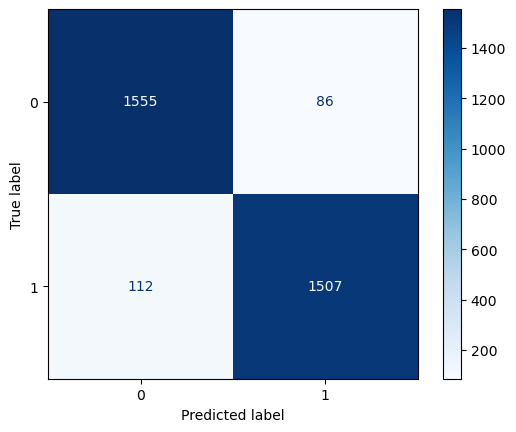

In [39]:
plot_confusion_matrix(gs_rf, X_test, y_test, cmap='Blues', values_format='d');

In [40]:
results = results.append({'model': 'Random Forest', 
                          'vectoriser': 'TF IDF Vectoriser',
                          'hyperparameters': gs_rf.best_params_, 
                          'recall/sensitivity': score,
                          'accuracy': acc}, ignore_index=True)
results

,model,vectoriser,hyperparameters,recall/sensitivity,accuracy
0,baseline,N/A,N/A,0.765749,0.811260
1,Naive Bayes,Count Vectoriser,"[(cvec, CountVectorizer(max_features=3000, min_df=3, ngram_range=(1, 2),\n stop_words='english')), (nb, MultinomialNB())]",0.908586,0.930368
2,Naive Bayes,TF IDF Vectoriser,"[(tvec, TfidfVectorizer(max_features=5000, min_df=3, ngram_range=(1, 2),\n stop_words='english')), (nb, MultinomialNB())]",0.912909,0.929141
3,Logistic Regression,TF IDF Vectoriser,"[(tvec, TfidfVectorizer(max_features=5000, min_df=3, ngram_range=(1, 3),\n stop_words='english')), (lr, LogisticRegression(max_iter=500, random_state=42))]",0.966028,0.950307
4,Random Forest,TF IDF Vectoriser,"{'rf__max_depth': None, 'rf__n_estimators': 300, 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}",0.930821,0.939264


### ROC-AUC curve

AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) is an important evaluation metric to check for classification model performance.
* The ROC curve is plotted with TPR against the FPR
* AUC is 0.99, near to the 1, indicating a good separability of 2 classes. Meaning the model have a good chance of distinguishing between 2 classes.

Tying back to the problem statement, we need to classify events to be routed or triaged to AWS services support team. The model selected to be used will be based on highest tpr/recall/sensitivity - Logistic Regression model with TF-IDF

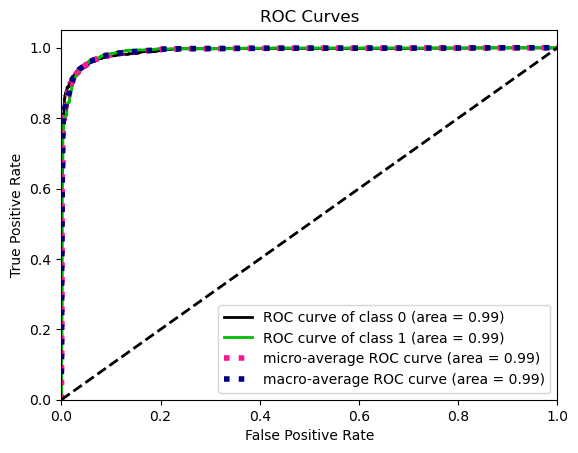

In [41]:
import scikitplot as skplt
import matplotlib.pyplot as plt


y_probas = gs_lr.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()